In [1]:
import warnings
warnings.filterwarnings("ignore")
from env import host, user, password
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import os
import acquire
import prepare

In [2]:
df = acquire.get_telco_db('telco_churn')

In [3]:
df.head()

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,3,0030-FNXPP,Female,0,No,No,3,Yes,...,No internet service,No internet service,No internet service,No,19.85,57.2,No,None,Month-to-month,Mailed check
1,2,1,3,0031-PVLZI,Female,0,Yes,Yes,4,Yes,...,No internet service,No internet service,No internet service,No,20.35,76.35,Yes,None,Month-to-month,Mailed check
2,1,1,3,0098-BOWSO,Male,0,No,No,27,Yes,...,No internet service,No internet service,No internet service,Yes,19.40,529.8,No,None,Month-to-month,Electronic check
3,1,1,3,0107-WESLM,Male,0,No,No,1,Yes,...,No internet service,No internet service,No internet service,Yes,19.85,19.85,Yes,None,Month-to-month,Electronic check
4,3,1,3,0114-RSRRW,Female,0,Yes,No,10,Yes,...,No internet service,No internet service,No internet service,Yes,19.95,187.75,No,None,Month-to-month,Bank transfer (automatic)


In [4]:
df.columns

Index(['payment_type_id', 'contract_type_id', 'internet_service_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'internet_service_type', 'contract_type',
       'payment_type'],
      dtype='object')

<AxesSubplot:xlabel='churn', ylabel='count'>

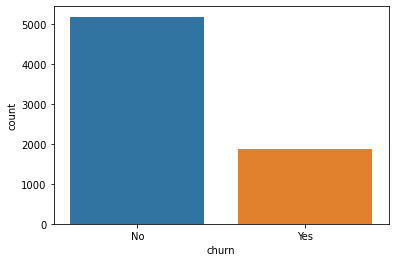

In [5]:
# Visualizing Churn
sns.countplot(df['churn'])

In [6]:
# Get percentages of churned and not churned

not_churned = df[df['churn']=='No']
churned = df[df['churn']=='Yes']

print(len(not_churned)/(len(churned)+len(not_churned)) * 100, '% of customers stayed with the company')
print(len(churned)/(len(churned)+len(not_churned)) * 100, '% of customers left the company')

73.4630129206304 % of customers stayed with the company
26.536987079369588 % of customers left the company


<AxesSubplot:xlabel='internet_service_type', ylabel='count'>

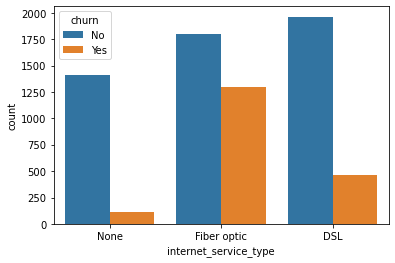

In [7]:
# Visualizing Churn by internet_service_type

sns.countplot(x='internet_service_type', hue='churn', data=df)

array([<AxesSubplot:title={'center':'tenure'}>,
       <AxesSubplot:title={'center':'monthly_charges'}>], dtype=object)

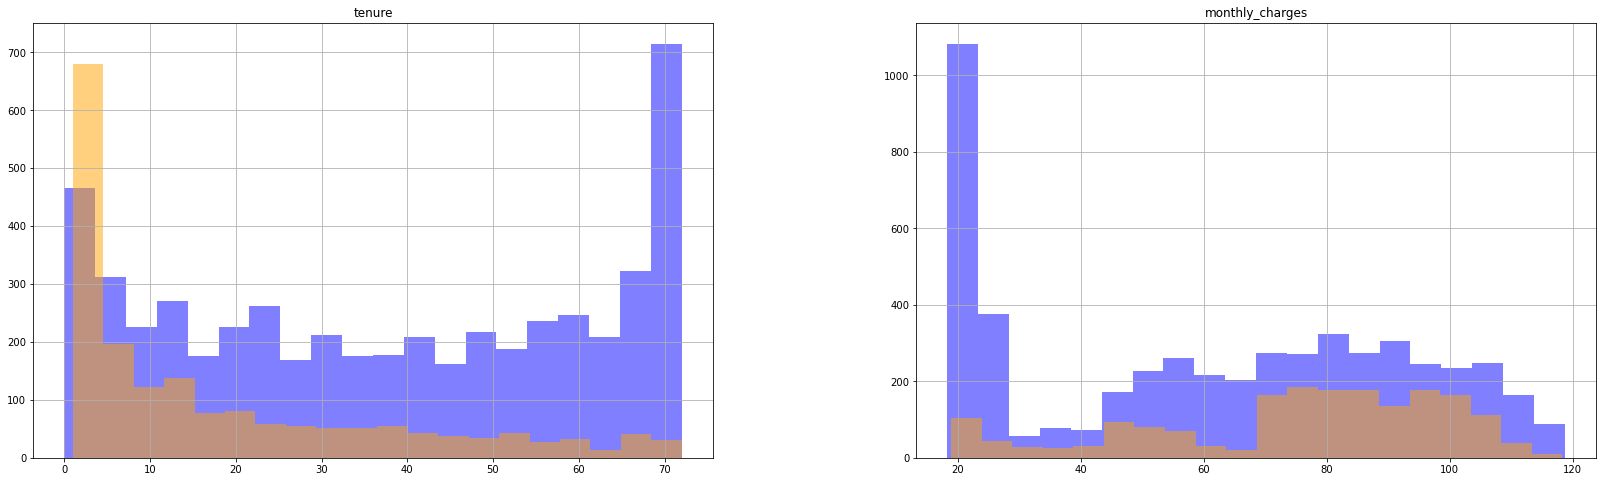

In [8]:
# Visualizing churn based on tenure and monthly_charges

features = ['tenure','monthly_charges']
fig, ax = plt.subplots(1, 2, figsize=(28,8))
not_churned[features].hist(bins=20, color='blue', alpha=0.5, ax = ax)
churned[features].hist(bins=20, color='orange', alpha=0.5, ax = ax)


In [9]:
# Drop customer_id

df = df.drop(['customer_id','payment_type_id','contract_type_id','internet_service_type_id','online_backup','device_protection','tech_support','streaming_tv','streaming_movies'], axis = 1)

In [10]:
# Drop empty total row charges

df.drop(df[df['total_charges'].str.contains(" ")].index, inplace = True)

In [11]:
df.shape

(7032, 15)

In [12]:
df.contract_type.value_counts()

Month-to-month    3875
Two year          1685
One year          1472
Name: contract_type, dtype: int64

In [13]:
# Convert non-numeric columns to numeric

for column in df.columns:
    if df[column].dtype == np.number:
        continue
    df[column] = LabelEncoder().fit_transform(df[column])

In [14]:
df.dtypes

gender                     int64
senior_citizen             int64
partner                    int64
dependents                 int64
tenure                     int64
phone_service              int64
multiple_lines             int64
online_security            int64
paperless_billing          int64
monthly_charges          float64
total_charges              int64
churn                      int64
internet_service_type      int64
contract_type              int64
payment_type               int64
dtype: object

In [15]:
df.contract_type.value_counts()

0    3875
2    1685
1    1472
Name: contract_type, dtype: int64

In [16]:
df.internet_service_type.value_counts()

1    3096
0    2416
2    1520
Name: internet_service_type, dtype: int64

In [17]:
df.churn.value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [18]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [19]:
train, validate, test = train_validate_test_split(df, target='churn', seed=123)

In [20]:
# Split the data
X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

### Hypothesis testing

In [21]:
alpha = .05

#### Is there a correlation between month-to-month contracts and churn?
"$H_0$ = Churn is independent of month-to-month contracts"

"$H_a$ = Month-to-month contracts and churn are dependent on each other."

In [22]:
observed = pd.crosstab(train['churn'], train['contract_type'])
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f"p value is less than alpha:  {p < alpha}")

p value is less than alpha:  True


#### Is there a correlation between fiber and churn
"$H_0$ = Churn is independent of fiber service."

"$H_a$ = Fiber service and churn are dependent on each other."

In [23]:
observed = pd.crosstab(train.churn, train.internet_service_type)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f"p value is less than alpha:  {p < alpha}")

p value is less than alpha:  True


In [24]:
train.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'internet_service_type', 'contract_type', 'payment_type'],
      dtype='object')

<AxesSubplot:>

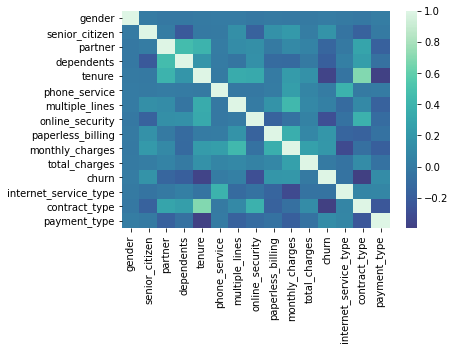

In [25]:
sns.heatmap(train.corr(), cmap='mako', center=0)

In [26]:
df.online_security.value_counts()

0    3497
2    2015
1    1520
Name: online_security, dtype: int64

In [27]:
df.internet_service_type.value_counts()

1    3096
0    2416
2    1520
Name: internet_service_type, dtype: int64

### Model 1

In [28]:
# Create model
logit = LogisticRegression(C=1, random_state=123)
# Train model
logit.fit(X_train, y_train)

LogisticRegression(C=1, random_state=123)

In [29]:
df.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'internet_service_type', 'contract_type', 'payment_type'],
      dtype='object')

In [30]:
# Feature Importance
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-1.00925414e-01  3.65779158e-01  4.05016569e-02 -4.03680884e-01
  -3.52082287e-02 -5.31793765e-01  1.38455771e-01 -3.93927627e-01
   2.57101008e-01  1.83103290e-02  9.04853973e-05 -9.73727924e-02
  -8.20045057e-01 -1.23081863e-01]]
Intercept: 
 [-0.53836176]


In [31]:
# monthly_charges and tenure are the top two important features, followed by contract_type

In [32]:
# Create predictions
y_pred = logit.predict(X_train)

print(y_pred)

[0 0 0 ... 0 0 0]


In [33]:
y_pred_proba = logit.predict_proba(X_train)

print(y_pred_proba)

[[0.97581448 0.02418552]
 [0.81619986 0.18380014]
 [0.99641849 0.00358151]
 ...
 [0.93825559 0.06174441]
 [0.6534324  0.3465676 ]
 [0.88345529 0.11654471]]


In [34]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.80


In [35]:
print(confusion_matrix(y_train, y_pred))


[[2597  294]
 [ 502  544]]


In [36]:
# Check precision, recall, f1-score
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2891
           1       0.65      0.52      0.58      1046

    accuracy                           0.80      3937
   macro avg       0.74      0.71      0.72      3937
weighted avg       0.79      0.80      0.79      3937



In [37]:
# Validate

y_pred1 = logit.predict(X_validate)

print("Model 1: solver = lbfgs, c = 1")

# accuracy of model 1
print('Accuracy: {:.2f}'.format(logit.score(X_validate, y_validate)))

# confusion matrix of model 1
print(confusion_matrix(y_validate, y_pred1))

# classification report of model 1
print(classification_report(y_validate, y_pred1))


Model 1: solver = lbfgs, c = 1
Accuracy: 0.80
[[1111  128]
 [ 216  233]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1239
           1       0.65      0.52      0.58       449

    accuracy                           0.80      1688
   macro avg       0.74      0.71      0.72      1688
weighted avg       0.79      0.80      0.79      1688



In [38]:
# Test

y_pred = logit.predict(X_test)
y_pred_proba = logit.predict_proba(X_test)

print("Model 1: solver = lbfgs, c = 1")

print('Accuracy: {:.2f}'.format(logit.score(X_test, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Model 1: solver = lbfgs, c = 1
Accuracy: 0.78
[[916 117]
 [188 186]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.61      0.50      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.78      1407



### Model 2 (Logistic Regression with less columns)

In [39]:
df.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'internet_service_type', 'contract_type', 'payment_type'],
      dtype='object')

In [40]:
train, validate, test = train_validate_test_split(df, target='churn', seed=123)

In [41]:
# Split the data
X_train = train.drop(columns=['gender','senior_citizen','partner','dependents','phone_service','multiple_lines','online_security','paperless_billing','total_charges','churn','internet_service_type','payment_type'])
y_train = train.churn

X_validate = validate.drop(columns=['gender','senior_citizen','partner','dependents','phone_service','multiple_lines','online_security','paperless_billing','total_charges','churn','internet_service_type','payment_type'])
y_validate = validate.churn

X_test = test.drop(columns=['gender','senior_citizen','partner','dependents','phone_service','multiple_lines','online_security','paperless_billing','total_charges','churn','internet_service_type','payment_type'])
y_test = test.churn

In [42]:
# Create model
logit = LogisticRegression(C=1,random_state=123)
# Train model
logit.fit(X_train, y_train)

LogisticRegression(C=1, random_state=123)

In [43]:
# Create predictions
y_pred = logit.predict(X_train)

print(y_pred)

[0 0 0 ... 0 1 0]


In [44]:
y_pred_proba = logit.predict_proba(X_train)

print(y_pred_proba)

[[0.94436527 0.05563473]
 [0.89301846 0.10698154]
 [0.99354655 0.00645345]
 ...
 [0.90556799 0.09443201]
 [0.34877675 0.65122325]
 [0.87898133 0.12101867]]


In [45]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.79


In [46]:
# Check precision, recall, f1-score
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2891
           1       0.63      0.50      0.56      1046

    accuracy                           0.79      3937
   macro avg       0.73      0.70      0.71      3937
weighted avg       0.78      0.79      0.78      3937



### KNN

In [47]:
train, validate, test = train_validate_test_split(df, target='churn', seed=123)
# Split the data
X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

In [48]:
# Create Model

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')


In [49]:
# Fit Model

knn.fit(X_train, y_train)


KNeighborsClassifier()

In [50]:
y_pred = knn.predict(X_train)


In [51]:
y_pred_proba = knn.predict_proba(X_train)


In [52]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.83


In [53]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.92      0.89      2891
           1       0.73      0.55      0.63      1046

    accuracy                           0.83      3937
   macro avg       0.79      0.74      0.76      3937
weighted avg       0.82      0.83      0.82      3937



In [54]:
knn.fit(X_validate, y_validate)


KNeighborsClassifier()

In [55]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on training set: 0.81
